#### Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re

from scipy.interpolate import interp1d # for time interpolation

from Sports2D import Sports2D

# importing custom plotting functions
from plotting_functions import plot_joint_angle, plot_all_joints, plot_hip_trajectory

from utilities import list_filepaths, load_multiple_files

#### Analysing the video's

In [2]:
# Set this to true if you need to re-analyse the videos :)
run_sports2d_analysis = True

In [4]:
import os
from Sports2D import Sports2D

# Define paths relative to the current script/notebook directory
script_dir = os.getcwd()

video_dir = os.path.normpath(os.path.join(script_dir, "../Videos to Analyze/Start Salto")) # switch to /Start Salto
config_path = os.path.normpath(os.path.join(script_dir, "../Configs/kraftspring_config_7nov.toml")) # still need to manually move analyzed videos and data to their respective folders (or change it in config)
data_dir = os.path.normpath(os.path.join(script_dir, "../Analyzed Data"))

# Specific move directories
kraft_data_dir = os.path.normpath(os.path.join(data_dir, "../Analyzed Data/Kraft"))
st_salto_data_dir = os.path.normpath(os.path.join(data_dir, "../Analyzed Data/Start Salto"))


# Get a list of all video files in the directory
video_files = list_filepaths(video_dir, [".mp4", ".mov"])

# Load the configuration file
config = Sports2D.read_config_file(config_path)


In [5]:
# Update the video input in the config and process each video

if run_sports2d_analysis == True:
    for video_file in video_files:
        try:
            config['project']['video_input'] = [video_file]
            Sports2D.process(config)
        except Exception as e:
            print(f"Error processing video {video_file}: {e}")



---------------------------------------------------------------------
Processing /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Videos to Analyze/Start Salto/stsalto_bad_id10_2.mov
On Wednesday 13. November 2024, 13:41:20
---------------------------------------------------------------------
  0%|          | 0/153 [00:00<?, ?it/s]
Valid MPS installation found: using ONNXRuntime backend with GPU.
2024-11-13 13:41:21.329807 [W:onnxruntime:, helper.cc:82 IsInputSupported] CoreML does not support input dim > 16384. Input:1475, shape: {400000,1}
2024-11-13 13:41:21.330038 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 8 number of nodes in the graph: 415 number of nodes supported by CoreML: 378
2024-11-13 13:41:24.810139 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigne

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend
load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


100%|██████████| 153/153 [00:14<00:00, 10.55it/s]
Video processing completed.
Processed video saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id10_2_Sports2D/stsalto_bad_id10_2_Sports2D.mp4.

Post-processing pose:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz.
Pose saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id10_2_Sports2D/stsalto_bad_id10_2_Sports2D_px_person00.trc.
- Person 1: Less than 4 valid frames. Deleting person.

Post-processing angles:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz. 
Angles saved 

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend


2024-11-13 13:41:38.178062 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 5 number of nodes in the graph: 247 number of nodes supported by CoreML: 204
2024-11-13 13:41:39.479065 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-11-13 13:41:39.479081 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
Pose tracking set up for BodyWithFeet model in balanced mode.
Persons are detected every 1 frames and tracked inbetween. Multi-person is selected.
Parameters: tracking_mode='sports2d', keypoint_likelihood_threshold=0.3, average_likelihood_threshold=0.5, keypoint_number_thres

load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


100%|██████████| 185/185 [00:14<00:00, 13.07it/s]
Video processing completed.
Processed video saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_good_id16_1_Sports2D/stsalto_good_id16_1_Sports2D.mp4.

Post-processing pose:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz.
Pose saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_good_id16_1_Sports2D/stsalto_good_id16_1_Sports2D_px_person00.trc.

Post-processing angles:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz. 
Angles saved to /Users/niels/Desktop/University/Third Semester/P

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend
load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


2024-11-13 13:41:52.492486 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 5 number of nodes in the graph: 247 number of nodes supported by CoreML: 204
Pose tracking set up for BodyWithFeet model in balanced mode.
2024-11-13 13:41:53.743689 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-11-13 13:41:53.743701 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
Persons are detected every 1 frames and tracked inbetween. Multi-person is selected.
Parameters: tracking_mode='sports2d', keypoint_likelihood_threshold=0.3, average_likelihood_threshold=0.5, keypoint_number_thres

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend
load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


Pose tracking set up for BodyWithFeet model in balanced mode.
Persons are detected every 1 frames and tracked inbetween. Multi-person is selected.
Parameters: tracking_mode='sports2d', keypoint_likelihood_threshold=0.3, average_likelihood_threshold=0.5, keypoint_number_threshold=0.3

Processing video stream...
100%|██████████| 177/177 [00:13<00:00, 13.21it/s]
Video processing completed.
Processed video saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_good_id12_1_Sports2D/stsalto_good_id12_1_Sports2D.mp4.

Post-processing pose:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz.
Pose saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_good_id12_1_

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend
load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


Pose tracking set up for BodyWithFeet model in balanced mode.
Persons are detected every 1 frames and tracked inbetween. Multi-person is selected.
Parameters: tracking_mode='sports2d', keypoint_likelihood_threshold=0.3, average_likelihood_threshold=0.5, keypoint_number_threshold=0.3

Processing video stream...
100%|██████████| 184/184 [00:14<00:00, 13.11it/s]
Video processing completed.
Processed video saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id14_1_Sports2D/stsalto_bad_id14_1_Sports2D.mp4.

Post-processing pose:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz.
Pose saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id14_1_Spo

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend


2024-11-13 13:42:29.852400 [W:onnxruntime:, helper.cc:82 IsInputSupported] CoreML does not support input dim > 16384. Input:1475, shape: {400000,1}
2024-11-13 13:42:29.852636 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 8 number of nodes in the graph: 415 number of nodes supported by CoreML: 378
2024-11-13 13:42:33.034396 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-11-13 13:42:33.034410 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2024-11-13 13:42:33.053251 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapabil

load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


100%|██████████| 201/201 [00:14<00:00, 13.74it/s]
Video processing completed.
Processed video saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id11_1_Sports2D/stsalto_bad_id11_1_Sports2D.mp4.

Post-processing pose:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz.
Pose saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id11_1_Sports2D/stsalto_bad_id11_1_Sports2D_px_person00.trc.

Post-processing angles:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz. 
Angles saved to /Users/niels/Desktop/University/Third Semester/Perce

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend


2024-11-13 13:42:47.805773 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 5 number of nodes in the graph: 247 number of nodes supported by CoreML: 204
2024-11-13 13:42:49.066025 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-11-13 13:42:49.066041 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
Pose tracking set up for BodyWithFeet model in balanced mode.
Persons are detected every 1 frames and tracked inbetween. Multi-person is selected.
Parameters: tracking_mode='sports2d', keypoint_likelihood_threshold=0.3, average_likelihood_threshold=0.5, keypoint_number_thres

load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


100%|██████████| 120/120 [00:10<00:00, 11.26it/s]
Video processing completed.
Processed video saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_good_id17_1_Sports2D/stsalto_good_id17_1_Sports2D.mp4.

Post-processing pose:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz.
Pose saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_good_id17_1_Sports2D/stsalto_good_id17_1_Sports2D_px_person00.trc.

Post-processing angles:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz. 
Angles saved to /Users/niels/Desktop/University/Third Semester/P

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend


2024-11-13 13:42:58.544100 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 5 number of nodes in the graph: 247 number of nodes supported by CoreML: 204
Pose tracking set up for BodyWithFeet model in balanced mode.
2024-11-13 13:42:59.853014 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-11-13 13:42:59.853028 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
Persons are detected every 1 frames and tracked inbetween. Multi-person is selected.
Parameters: tracking_mode='sports2d', keypoint_likelihood_threshold=0.3, average_likelihood_threshold=0.5, keypoint_number_thres

load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


100%|██████████| 154/154 [00:12<00:00, 12.21it/s]
Video processing completed.
Processed video saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id11_3_Sports2D/stsalto_bad_id11_3_Sports2D.mp4.

Post-processing pose:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz.
Pose saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id11_3_Sports2D/stsalto_bad_id11_3_Sports2D_px_person00.trc.

Post-processing angles:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz. 
Angles saved to /Users/niels/Desktop/University/Third Semester/Perce

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend
load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


Pose tracking set up for BodyWithFeet model in balanced mode.
Persons are detected every 1 frames and tracked inbetween. Multi-person is selected.
Parameters: tracking_mode='sports2d', keypoint_likelihood_threshold=0.3, average_likelihood_threshold=0.5, keypoint_number_threshold=0.3

Processing video stream...
100%|██████████| 184/184 [00:13<00:00, 13.14it/s]
Video processing completed.
Processed video saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id11_2_Sports2D/stsalto_bad_id11_2_Sports2D.mp4.

Post-processing pose:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz.
Pose saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id11_2_Spo

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend
load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


2024-11-13 13:43:22.287189 [W:onnxruntime:, helper.cc:82 IsInputSupported] CoreML does not support input dim > 16384. Input:1475, shape: {400000,1}
2024-11-13 13:43:22.287449 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 8 number of nodes in the graph: 415 number of nodes supported by CoreML: 378
2024-11-13 13:43:25.501178 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-11-13 13:43:25.501191 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2024-11-13 13:43:25.522419 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapabil

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend
load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


2024-11-13 13:43:37.937560 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-11-13 13:43:37.937574 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
Pose tracking set up for BodyWithFeet model in balanced mode.
Persons are detected every 1 frames and tracked inbetween. Multi-person is selected.
Parameters: tracking_mode='sports2d', keypoint_likelihood_threshold=0.3, average_likelihood_threshold=0.5, keypoint_number_threshold=0.3

Processing video stream...
100%|██████████| 177/177 [00:13<00:00, 13.08it/s]
Video processing completed.
Processed video saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for G

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend
load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


Parameters: tracking_mode='sports2d', keypoint_likelihood_threshold=0.3, average_likelihood_threshold=0.5, keypoint_number_threshold=0.3

Processing video stream...
100%|██████████| 233/233 [00:16<00:00, 14.39it/s]
Video processing completed.
Processed video saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id9_2_Sports2D/stsalto_bad_id9_2_Sports2D.mp4.

Post-processing pose:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz.
Pose saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id9_2_Sports2D/stsalto_bad_id9_2_Sports2D_px_person00.trc.
- Person 1: Less than 4 valid frames. Deleting person.
- Person 2: Less than 4 valid frames. Deletin

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend


2024-11-13 13:44:03.633523 [W:onnxruntime:, helper.cc:82 IsInputSupported] CoreML does not support input dim > 16384. Input:1475, shape: {400000,1}
2024-11-13 13:44:03.633817 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 8 number of nodes in the graph: 415 number of nodes supported by CoreML: 378
2024-11-13 13:44:06.796411 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-11-13 13:44:06.796424 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2024-11-13 13:44:06.818002 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapabil

load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


100%|██████████| 208/208 [00:15<00:00, 13.80it/s]
Video processing completed.
Processed video saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id15_1_Sports2D/stsalto_bad_id15_1_Sports2D.mp4.

Post-processing pose:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz.
Pose saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id15_1_Sports2D/stsalto_bad_id15_1_Sports2D_px_person00.trc.

Post-processing angles:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz. 
Angles saved to /Users/niels/Desktop/University/Third Semester/Perce

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend


2024-11-13 13:44:22.016235 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 5 number of nodes in the graph: 247 number of nodes supported by CoreML: 204
2024-11-13 13:44:23.299217 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-11-13 13:44:23.299227 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
Pose tracking set up for BodyWithFeet model in balanced mode.
Persons are detected every 1 frames and tracked inbetween. Multi-person is selected.
Parameters: tracking_mode='sports2d', keypoint_likelihood_threshold=0.3, average_likelihood_threshold=0.5, keypoint_number_thres

load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


100%|██████████| 171/171 [00:13<00:00, 12.98it/s]
Video processing completed.
Processed video saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_good_id13_1_Sports2D/stsalto_good_id13_1_Sports2D.mp4.

Post-processing pose:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz.
Pose saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_good_id13_1_Sports2D/stsalto_good_id13_1_Sports2D_px_person00.trc.
- Person 1: Less than 4 valid frames. Deleting person.

Post-processing angles:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz. 
Angles sa

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend


2024-11-13 13:44:32.162500 [W:onnxruntime:, helper.cc:82 IsInputSupported] CoreML does not support input dim > 16384. Input:1475, shape: {400000,1}
2024-11-13 13:44:32.162737 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 8 number of nodes in the graph: 415 number of nodes supported by CoreML: 378
2024-11-13 13:44:35.294943 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-11-13 13:44:35.294963 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2024-11-13 13:44:35.328563 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapabil

load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


100%|██████████| 172/172 [00:13<00:00, 12.90it/s]
Video processing completed.
Processed video saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id9_3_Sports2D/stsalto_bad_id9_3_Sports2D.mp4.

Post-processing pose:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz.
Pose saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id9_3_Sports2D/stsalto_bad_id9_3_Sports2D_px_person00.trc.
- Person 1: Less than 4 valid frames. Deleting person.

Post-processing angles:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz. 
Angles saved to /

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend


2024-11-13 13:44:45.634693 [W:onnxruntime:, helper.cc:82 IsInputSupported] CoreML does not support input dim > 16384. Input:1475, shape: {400000,1}
2024-11-13 13:44:45.634933 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 8 number of nodes in the graph: 415 number of nodes supported by CoreML: 378
2024-11-13 13:44:48.783418 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-11-13 13:44:48.783432 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2024-11-13 13:44:48.804227 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapabil

load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


100%|██████████| 261/261 [00:17<00:00, 14.77it/s]
Video processing completed.
Processed video saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id7_1_Sports2D/stsalto_bad_id7_1_Sports2D.mp4.

Post-processing pose:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz.
Pose saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id7_1_Sports2D/stsalto_bad_id7_1_Sports2D_px_person00.trc.

Post-processing angles:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz. 
Angles saved to /Users/niels/Desktop/University/Third Semester/Perceptio

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend


2024-11-13 13:45:03.462435 [W:onnxruntime:, helper.cc:82 IsInputSupported] CoreML does not support input dim > 16384. Input:1475, shape: {400000,1}
2024-11-13 13:45:03.462713 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 8 number of nodes in the graph: 415 number of nodes supported by CoreML: 378
2024-11-13 13:45:06.691091 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-11-13 13:45:06.691105 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2024-11-13 13:45:06.714221 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapabil

load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


100%|██████████| 264/264 [00:18<00:00, 14.64it/s]
Video processing completed.
Processed video saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id5_1_Sports2D/stsalto_bad_id5_1_Sports2D.mp4.

Post-processing pose:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz.
Pose saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id5_1_Sports2D/stsalto_bad_id5_1_Sports2D_px_person00.trc.
- Person 1: Less than 4 valid frames. Deleting person.

Post-processing angles:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz. 
Angles saved to /

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend
load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


2024-11-13 13:45:24.816846 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 5 number of nodes in the graph: 247 number of nodes supported by CoreML: 204
2024-11-13 13:45:26.097767 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-11-13 13:45:26.097780 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
Pose tracking set up for BodyWithFeet model in balanced mode.
Persons are detected every 1 frames and tracked inbetween. Multi-person is selected.
Parameters: tracking_mode='sports2d', keypoint_likelihood_threshold=0.3, average_likelihood_threshold=0.5, keypoint_number_thres

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend


2024-11-13 13:45:36.630678 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 5 number of nodes in the graph: 247 number of nodes supported by CoreML: 204
2024-11-13 13:45:37.886016 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-11-13 13:45:37.886030 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
Pose tracking set up for BodyWithFeet model in balanced mode.
Persons are detected every 1 frames and tracked inbetween. Multi-person is selected.
Parameters: tracking_mode='sports2d', keypoint_likelihood_threshold=0.3, average_likelihood_threshold=0.5, keypoint_number_thres

load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


100%|██████████| 467/467 [00:26<00:00, 17.33it/s]
Video processing completed.
Processed video saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_good_id8_1_Sports2D/stsalto_good_id8_1_Sports2D.mp4.

Post-processing pose:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz.
Pose saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_good_id8_1_Sports2D/stsalto_good_id8_1_Sports2D_px_person00.trc.
- Person 1: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz.
Pose saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnas

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend


2024-11-13 13:46:00.566608 [W:onnxruntime:, helper.cc:82 IsInputSupported] CoreML does not support input dim > 16384. Input:1475, shape: {400000,1}
2024-11-13 13:46:00.566856 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 8 number of nodes in the graph: 415 number of nodes supported by CoreML: 378
2024-11-13 13:46:03.780147 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-11-13 13:46:03.780160 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2024-11-13 13:46:03.798135 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapabil

load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


100%|██████████| 142/142 [00:12<00:00, 11.82it/s]
Video processing completed.
Processed video saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_good_id8_2_Sports2D/stsalto_good_id8_2_Sports2D.mp4.

Post-processing pose:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz.
Pose saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_good_id8_2_Sports2D/stsalto_good_id8_2_Sports2D_px_person00.trc.

Post-processing angles:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz. 
Angles saved to /Users/niels/Desktop/University/Third Semester/Perce

load /Users/niels/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend


2024-11-13 13:46:15.862012 [W:onnxruntime:, coreml_execution_provider.cc:115 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 5 number of nodes in the graph: 247 number of nodes supported by CoreML: 204
2024-11-13 13:46:17.131369 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-11-13 13:46:17.131386 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
Pose tracking set up for BodyWithFeet model in balanced mode.
Persons are detected every 1 frames and tracked inbetween. Multi-person is selected.
Parameters: tracking_mode='sports2d', keypoint_likelihood_threshold=0.3, average_likelihood_threshold=0.5, keypoint_number_thres

load /Users/niels/.cache/rtmlib/hub/checkpoints/rtmpose-m_simcc-body7_pt-body7-halpe26_700e-256x192-4d3e73dd_20230605.onnx with onnxruntime backend


100%|██████████| 197/197 [00:14<00:00, 13.33it/s]
Video processing completed.
Processed video saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id2_1_Sports2D/stsalto_bad_id2_1_Sports2D.mp4.

Post-processing pose:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz.
Pose saved to /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Start Salto/stsalto_bad_id2_1_Sports2D/stsalto_bad_id2_1_Sports2D_px_person00.trc.

Post-processing angles:
- Person 0: Interpolating missing sequences if they are smaller than 10 frames. Large gaps filled with last_value.
Filtering with Butterworth filter, 4th order, 3 Hz. 
Angles saved to /Users/niels/Desktop/University/Third Semester/Perceptio

#### Loading Data

In [20]:
# get file paths contained in analyzed video data
kraft_trc_file_paths = list_filepaths(kraft_data_dir, '.trc')
kraft_mot_file_paths = list_filepaths(kraft_data_dir, '.mot')


# create combined dataframes of them
kraft_trc_combined_df = load_multiple_files(kraft_trc_file_paths, file_type='trc')
kraft_mot_combined_df = load_multiple_files(kraft_mot_file_paths, file_type='mot')


# get file paths contained in analyzed video data
st_salto_trc_file_paths = list_filepaths(st_salto_data_dir, '.trc')
st_salto_mot_file_paths = list_filepaths(st_salto_data_dir, '.mot')


# create combined dataframes of them
st_salto_trc_combined_df = load_multiple_files(st_salto_trc_file_paths, file_type='trc')
st_salto_mot_combined_df = load_multiple_files(st_salto_mot_file_paths, file_type='mot')

# combine all the dataframes in one large one
#all_trc_moves_df = pd.concat([kraft_trc_combined_df, st_salto_trc_combined_df], axis=1)

all_mot_moves_df = pd.concat([kraft_mot_combined_df, st_salto_mot_combined_df], axis=0)

8 columns passed, passed data had 7 columns


In [22]:
print(all_mot_moves_df.head())

# number of rows in all_mot_moves_df
print(all_mot_moves_df.shape[0])
print(kraft_mot_combined_df.shape[0])
print(st_salto_mot_combined_df.shape[0])

       time  right_knee  left_knee   left_hip  right_shoulder  left_shoulder  \
0  0.000000  101.097969   7.277865  68.480268      174.192347     114.094754   
1  0.006971  101.122264   7.238547  68.518884      174.222379     114.053705   
2  0.013943  101.150709   7.195587  68.543118      174.240329     114.016246   
3  0.020914  101.183615   7.149052  68.549590      174.243401     113.983813   
4  0.027886  101.221266   7.099094  68.534564      174.228512     113.958039   

   right_elbow  left_elbow version nRows nColumns inDegrees participant_id  \
0   -38.207582    6.191491       1   258        7       yes   id2_person00   
1   -38.263336    6.183936       1   258        7       yes   id2_person00   
2   -38.298380    6.175673       1   258        7       yes   id2_person00   
3   -38.307839    6.166714       1   258        7       yes   id2_person00   
4   -38.286334    6.157085       1   258        7       yes   id2_person00   

    move evaluation video_number  
0  kraft       

In [23]:
print(f"Unique columns in the combined dataframe: {all_mot_moves_df.columns.unique()}")

print(f"Unique moves in the combined dataframe: {all_mot_moves_df['move'].unique()}")

Unique columns in the combined dataframe: Index(['time', 'right_knee', 'left_knee', 'left_hip', 'right_shoulder',
       'left_shoulder', 'right_elbow', 'left_elbow', 'version', 'nRows',
       'nColumns', 'inDegrees', 'participant_id', 'move', 'evaluation',
       'video_number'],
      dtype='object')
Unique moves in the combined dataframe: ['kraft' 'stsalto']


In [25]:
print(f"Unique participants in mot_files {all_mot_moves_df['participant_id'].unique()}")

print()
print(f"Unique moves in mot_files {all_mot_moves_df['move'].unique()}")

print()
print(f"Unique evaluations in mot_files {all_mot_moves_df['evaluation'].unique()}")

print()
print(f"Unique video numbers in mot_files {all_mot_moves_df['video_number'].unique()}")

Unique participants in mot_files ['id2_person00' 'id5_person00' 'id3_person00' 'id1_person00'
 'id12_person00' 'id15_person00' 'id9_person01' 'id9_person00'
 'id10_person00' 'id17_person00' 'id11_person00' 'id8_person00'
 'id16_person00' 'id13_person00' 'id14_person00' 'id7_person00']

Unique moves in mot_files ['kraft' 'stsalto']

Unique evaluations in mot_files ['good' 'bad']

Unique video numbers in mot_files ['1' '2' '3']


#### Plotting!

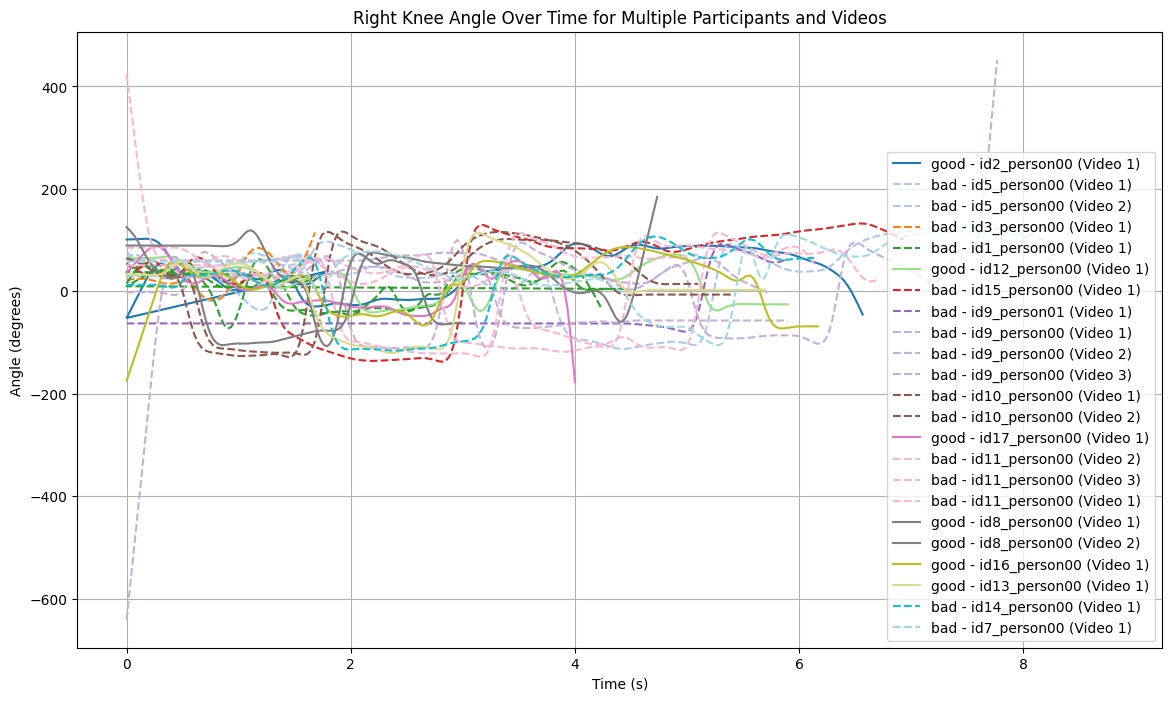

In [26]:
# Assuming combined_trc_df and combined_mot_df are DataFrames with motion capture data
#plot_hip_trajectory(trc_combined_df)
#standardized_trc_df = standardize_trc_data(trc_combined_df)
plot_joint_angle(all_mot_moves_df, 'right_knee')

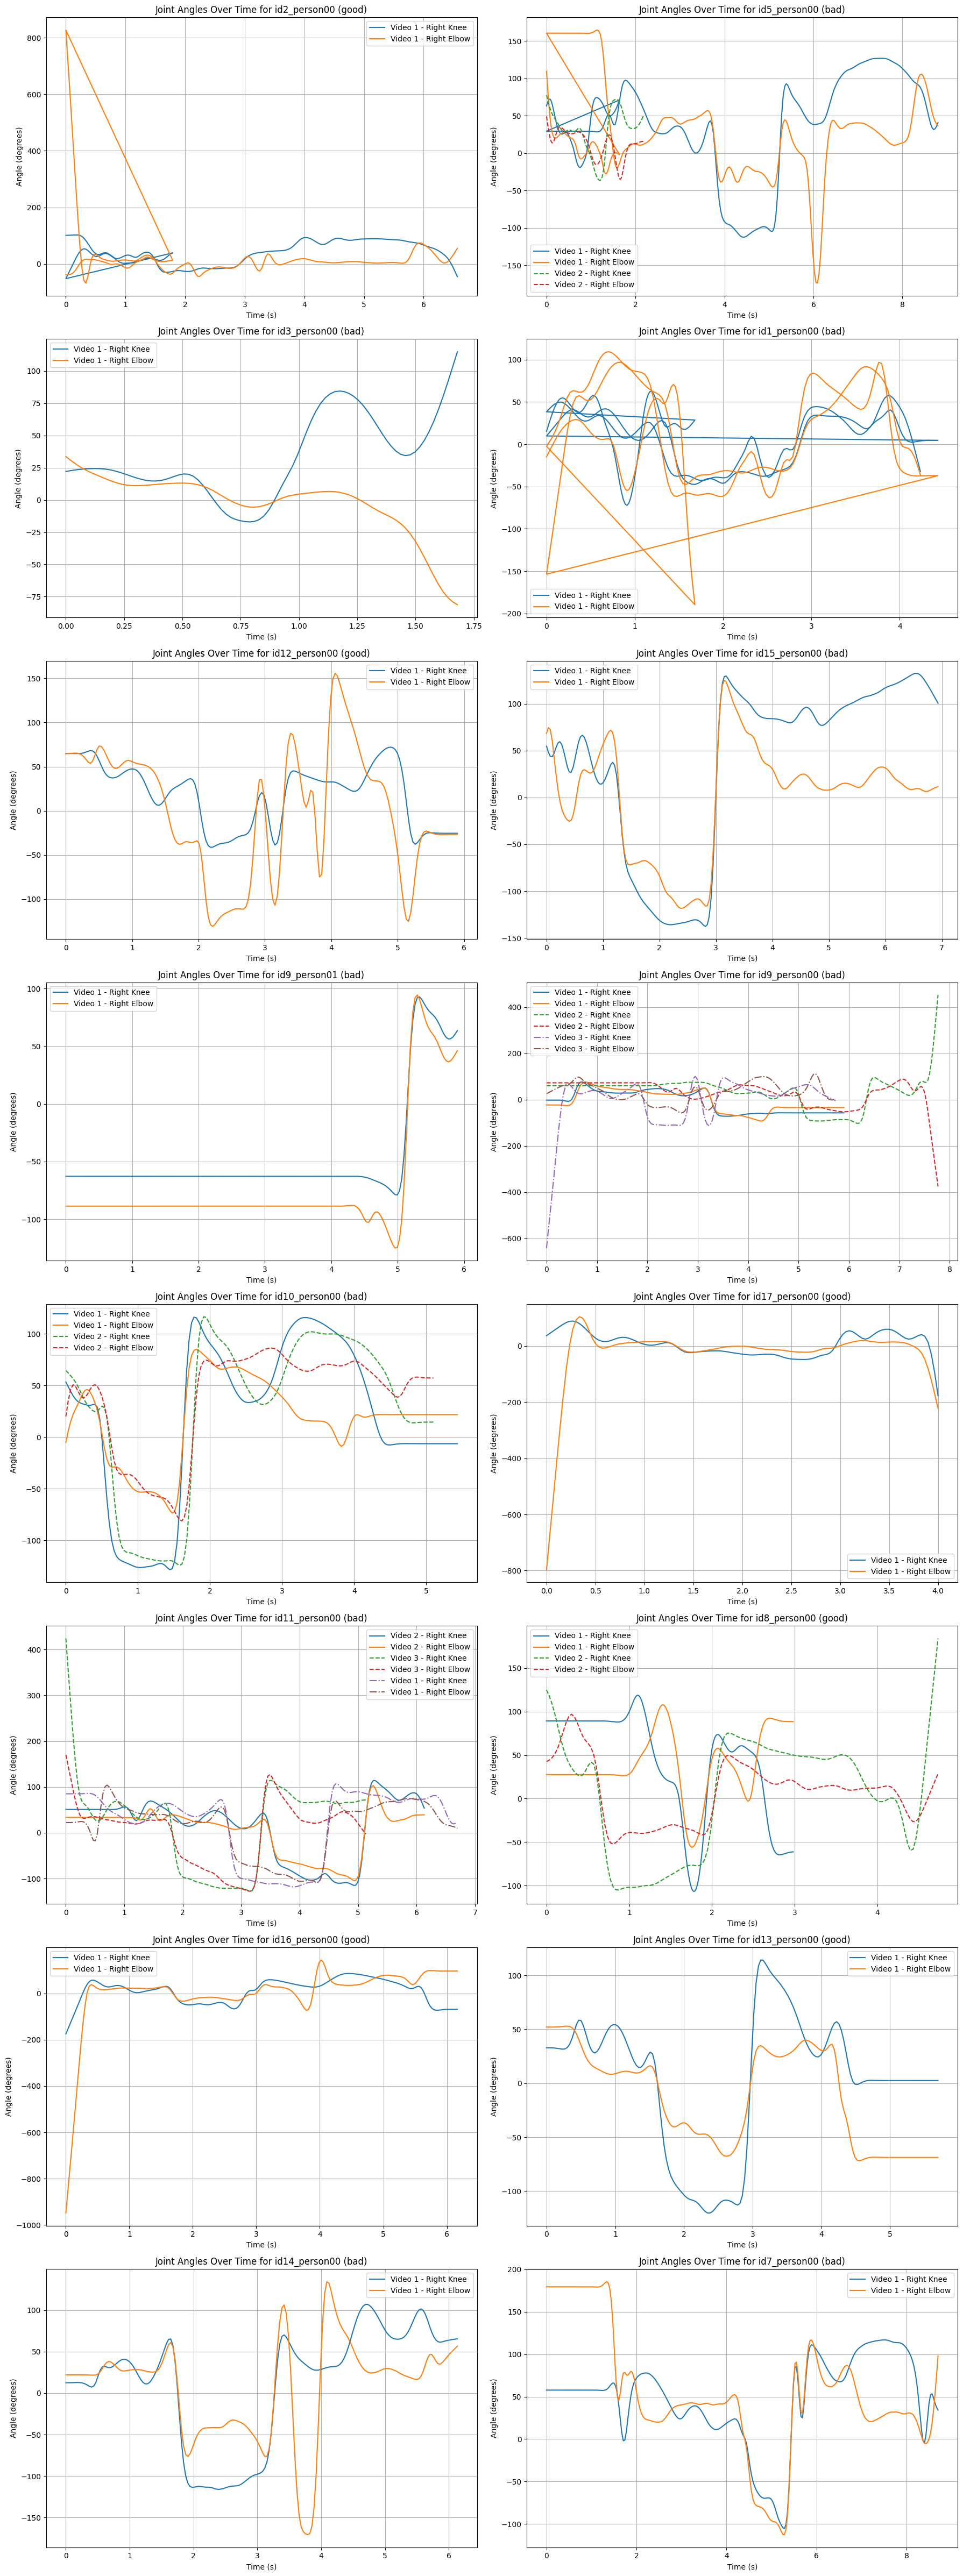

In [27]:
# Example usage with a DataFrame containing joint data
joint_names = ['right_knee', 'right_elbow']  # List of joints to plot
plot_all_joints(all_mot_moves_df, joint_names, grid=True, fig_size = (18, 6))
